**<font color='blue' size="+2.5">PROYECTO DETECCIÓN DE FALLAS POR DESBALANCE EN MOTORES ELÉCTRICOS</font>**

Este proyecto tiene como objetivo desarrollar un modelo de aprendizaje automático para detectar problemas de desbalance en motores eléctricos mediante el análisis de datos de vibraciones. Se explorará cómo las características de las señales de vibración pueden indicar la presencia de desbalance en el motor, lo cual es crucial para mejorar la detección temprana de fallas en maquinaria industrial.
.


**<font color='blue' size="+1">Importación de Librerías y Preparación del Entorno</font>**

En esta sección, se importan las librerías necesarias y se prepara el entorno de trabajo para el análisis de datos y la construcción del modelo de aprendizaje automático.


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from tqdm import tqdm


 **<font color="blue">Origen y Composición de los Datos</font>**

Los datos utilizados en este proyecto provienen del Simulador de Fallas de Maquinaria (MFS) de SpectraQuest, que simula diferentes estados de fallas en motores eléctricos para este caso, nos centramos en las fallas que representan desbalance.  Cada archivo CSV contiene series de tiempo multivariadas adquiridas por sensores en el MFS.

Cantidad Total de Instancias: Aproximadamente 250,000 filas por archivo CSV.
Cantidad total de clases: 8 por cada archivo.
Los datos se encuentran balanceados.

Características por Instancia: Incluyen 8 señales, las cuales son  señal del tacómetro, acelerómetros de soportes, rodamientos y micrófono.

Uso en este Proyecto: Se utilizó una muestra reducida de 231 mb, de la cual a lo largo del proyecto se redujo a la mitad del total (3gb) de los datos debido a la gran cantidad disponible.

**<font color='blue' size="+1">Carga de Archivos de Datos</font>**

En esta sección, se cargan los datos de los archivos CSV que representan mediciones de motores en funcionamiento normal y con diferentes niveles de desbalance.

In [2]:


# Ruta donde se encuentran los archivos normales
ruta_normales = r'C:\Users\Usuario\Desktop\TECNICATURA\APRENDIZAJE AUTOMATICO\PROYECTO FALLAS\PROYECTO-DETECCION-DE-FALLA\cookiecutter-data-science\datos\NORMAL\DATOS NORMAL UNIFICADO'

# Lista para almacenar DataFrames individuales de datos normales
dfs_normales = []

# Leer cada archivo CSV de la carpeta de datos normales y almacenar en la lista
for filename in os.listdir(ruta_normales):
    if filename.endswith('.csv'):
        filepath = os.path.join(ruta_normales, filename)
        df = pd.read_csv(filepath, header=None) 
        dfs_normales.append(df)

# Concatenar todos los DataFrames de datos normales en uno solo
df_normales = pd.concat(dfs_normales, ignore_index=True)

# Renombramos las columnas según la distribución de los sensores.
columnas_normales = [
   'Taco.', 
    'Acel.Sop.Ax.', 
    'Acel.Sop.Rad.', 
    'Acel.Sop.Tang.', 
    'Acel.Rod.Ax.', 
    'Acel.Rod.Rad.', 
    'Acel.Rod.Tang.', 
    'Mic.'
]

# Asignamos los nombres de columnas al DataFrame concatenado
df_normales.columns = columnas_normales

# Verificamos la forma y tamaño del DataFrame resultante.
print("Datos Normales:")
print(f"Total de filas: {df_normales.shape[0]}")
print(f"Columnas: {df_normales.shape[1]}")



Datos Normales:
Total de filas: 1750000
Columnas: 8


In [3]:


# Cargamos los archivos con desbalance
ruta_desbalances = r'C:\Users\Usuario\Desktop\TECNICATURA\APRENDIZAJE AUTOMATICO\PROYECTO FALLAS\PROYECTO-DETECCION-DE-FALLA\cookiecutter-data-science\datos\DESBALANCES\DATOS DESBALANCE UNIFICADO'

# Creamos una lista para almacenar DataFrames individuales de datos los archivos desbalanceados
dfs_desbalances = []

# leemos cada archivo CSV de la carpeta de datos desbalanceados y almacenamos en la lista
for filename in os.listdir(ruta_desbalances):
    if filename.endswith('.csv'):
        filepath = os.path.join(ruta_desbalances, filename)
        df = pd.read_csv(filepath, header=None)  
        dfs_desbalances.append(df)

# Concatenamos todos los DataFrames de datos los archivos desbalanceados en uno solo
df_desbalances = pd.concat(dfs_desbalances, ignore_index=True)

# Nombro todas de columnas según la distribución de los sensores 
columnas_desbalances = [
    'Taco.', 
    'Acel.Sop.Ax.', 
    'Acel.Sop.Rad.', 
    'Acel.Sop.Tang.', 
    'Acel.Rod.Ax.', 
    'Acel.Rod.Rad.', 
    'Acel.Rod.Tang.', 
    'Mic.'
]

# Asigno los nombres de columnas al DataFrame concatenado
df_desbalances.columns = columnas_desbalances

# Verificamos la forma y tamaño del DataFrame resultante.
print("Datos Desbalanceados:")
print(f"Total de filas: {df_desbalances.shape[0]}")
print(f"Columnas: {df_desbalances.shape[1]}")



Datos Desbalanceados:
Total de filas: 1750000
Columnas: 8


In [4]:
# Mostramos las primeras filas del DataFrame df_normales
print("Primeras filas del DataFrame df_normales:")
print(df_normales.head())

# Mostramos las primeras filas del DataFrame df_desbalances
print("\nPrimeras filas del DataFrame df_desbalances:")
print(df_desbalances.head())



Primeras filas del DataFrame df_normales:
    Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  Acel.Rod.Ax.  \
0  4.5595      0.175200       0.287210       -0.017751      -0.41565   
1  4.6038     -0.051295      -0.194050       -0.060071      -0.41809   
2  4.5703     -0.969080       0.038033       -0.028329      -0.43081   
3  4.5870      0.891270       0.072973        0.007453      -0.40017   
4  4.5887     -1.716000      -0.329290       -0.033063      -0.50281   

   Acel.Rod.Rad.  Acel.Rod.Tang.      Mic.  
0       0.032459        -0.11218 -0.128140  
1       0.036547        -0.11043  0.118310  
2       0.041924        -0.14331 -0.071527  
3       0.041090        -0.11984  0.043445  
4       0.040474        -0.25270  0.023901  

Primeras filas del DataFrame df_desbalances:
     Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  Acel.Rod.Ax.  \
0 -0.89277      -0.45756        -1.8349        -0.37923       0.12792   
1 -0.84238      -0.77687        -2.8056        -0.11675       0


**<font color= "blue">Análisis de Diferencias entre Datos Normales y Desbalanceados</font>**

 **Calculo de Diferencia Absoluta por Columna:**
   Se calcula la diferencia absoluta entre los valores de cada columna para los DataFrames de datos normales y desbalanceados. Esto proporciona una medida cuantitativa de la discrepancia entre ambos conjuntos de datos.


**<font color='blue' size='+1'>Exploración de Datos</font>**

En este punto, realizaremos gráficos que nos permitan visualizar las relaciones y distribuciones de nuestras variables. El objetivo es identificar patrones ocultos, detectar posibles discrepancias o valores atípicos que puedan afectar la calidad de los datos.

In [5]:


# Calculamos la diferencia absoluta entre los DataFrames (normal y desbalance)
diferencia_absoluta = np.abs(df_normales - df_desbalances)


In [6]:
# Calculamos la media de la diferencia para cada columna
media_diferencia = diferencia_absoluta.mean()


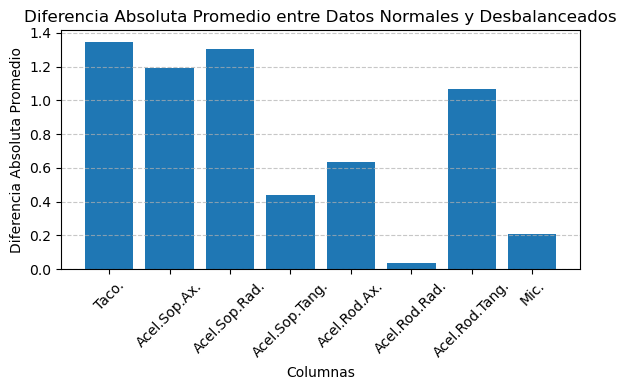

In [7]:

# Creamos un gráfico de barras para visualizar las diferencias
plt.figure(figsize=(6, 4))
plt.bar(df_normales.columns, media_diferencia)
plt.xlabel('Columnas')
plt.ylabel('Diferencia Absoluta Promedio')
plt.title('Diferencia Absoluta Promedio entre Datos Normales y Desbalanceados')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



**<font color = "blue">Conclusión</font>** Esta comparación revela qué columnas son más relevantes para discernir entre condiciones normales y desbalanceadas. Se puede observar que las columnas de Acel. Sop. Colg. Tang. y Acel. Rod. Sal. Tang. presentan una mayor discrepancia promedio entre los datos normales y desbalanceados, lo cual nos indica que estos sensores podrían ser especialmente informativos para detectar fallos o condiciones de desbalance en el sistema analizado.


**<font color= "blue">"Diagrama de correlación</font>**
Buscaremos entender las relaciones entre las variables medidas por los sensores, evaluar si hay dependencias significativas entre ellos y detectar cómo estas relaciones cambian entre datos normales y desbalanceados. 

In [8]:
# Calculamos la matriz de correlación para datos normales y desbalanceados
correlacion_normales = df_normales.corr()
correlacion_desbalances = df_desbalances.corr()

# Visualizamos las matrices de correlación
print("Matriz de correlación para datos normales:")
print(correlacion_normales)

print("\nMatriz de correlación para datos desbalanceados:")
print(correlacion_desbalances)


Matriz de correlación para datos normales:
                   Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  \
Taco.           1.000000     -0.022030       0.040068       -0.051302   
Acel.Sop.Ax.   -0.022030      1.000000       0.662000        0.506465   
Acel.Sop.Rad.   0.040068      0.662000       1.000000        0.549760   
Acel.Sop.Tang. -0.051302      0.506465       0.549760        1.000000   
Acel.Rod.Ax.    0.192048      0.036984       0.056641        0.020114   
Acel.Rod.Rad.   0.095672      0.014515       0.027479        0.006232   
Acel.Rod.Tang.  0.151271      0.123114       0.128109        0.055495   
Mic.            0.008714     -0.431600      -0.765136       -0.534972   

                Acel.Rod.Ax.  Acel.Rod.Rad.  Acel.Rod.Tang.      Mic.  
Taco.               0.192048       0.095672        0.151271  0.008714  
Acel.Sop.Ax.        0.036984       0.014515        0.123114 -0.431600  
Acel.Sop.Rad.       0.056641       0.027479        0.128109 -0.765136  
Acel.Sop.Ta

**<font color = "blue">Verificación mediante grafico</font>**


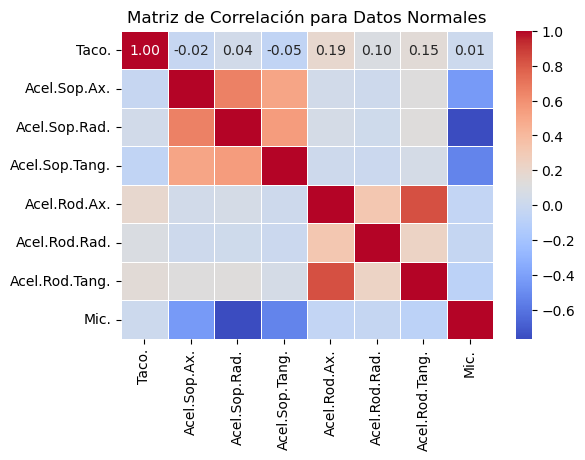

In [9]:

# Calculamos la matriz de correlación para datos normales
correlacion_normales = df_normales.corr()

# Creamos un mapa de calor para la matriz de correlación de datos normales
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion_normales, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación para Datos Normales')
plt.show()


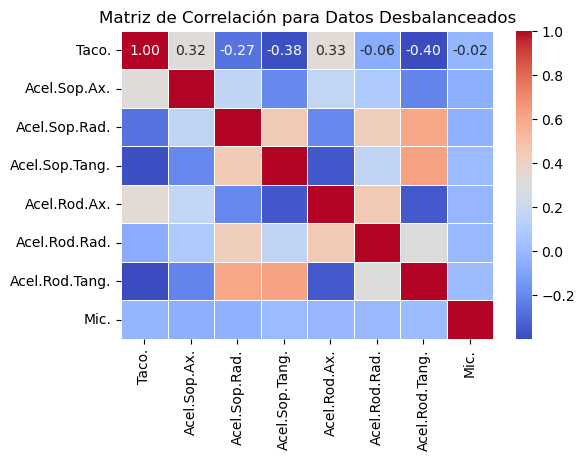

In [10]:
# Nuevamente calculamos la matriz de correlación para datos normales
correlacion_desbalances = df_desbalances.corr()

# Generamos tambien un mapa de calor para la matriz de correlación de datos desbalanceados
plt.figure(figsize=(6, 4))
sns.heatmap(correlacion_desbalances, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación para Datos Desbalanceados')
plt.show()


**<font color = "blue">Conclusiones Principales:</font>**

Patrones de Correlación: En datos normales, los sensores de acelerómetro radial en el soporte (Acel.Sop.Rad.) muestran una correlación positiva significativa con otros sensores de soporte y rodamiento. Sin embargo, en datos desbalanceados, estas correlaciones cambian drásticamente, sugiriendo alteraciones en las interacciones entre componentes del sistema, evidenciado la clara diferencia entre un motor con desbalance y estado normal..


**<font color = "blue">Histograma combinado</font>**
 Buscaremos identificar visualmente diferencias significativas en las distribuciones de variables entre condiciones operativas normales y desbalanceadas para evaluar el impacto del desbalance en el sistema y seleccionar variables relevantes para análisis y modelado.

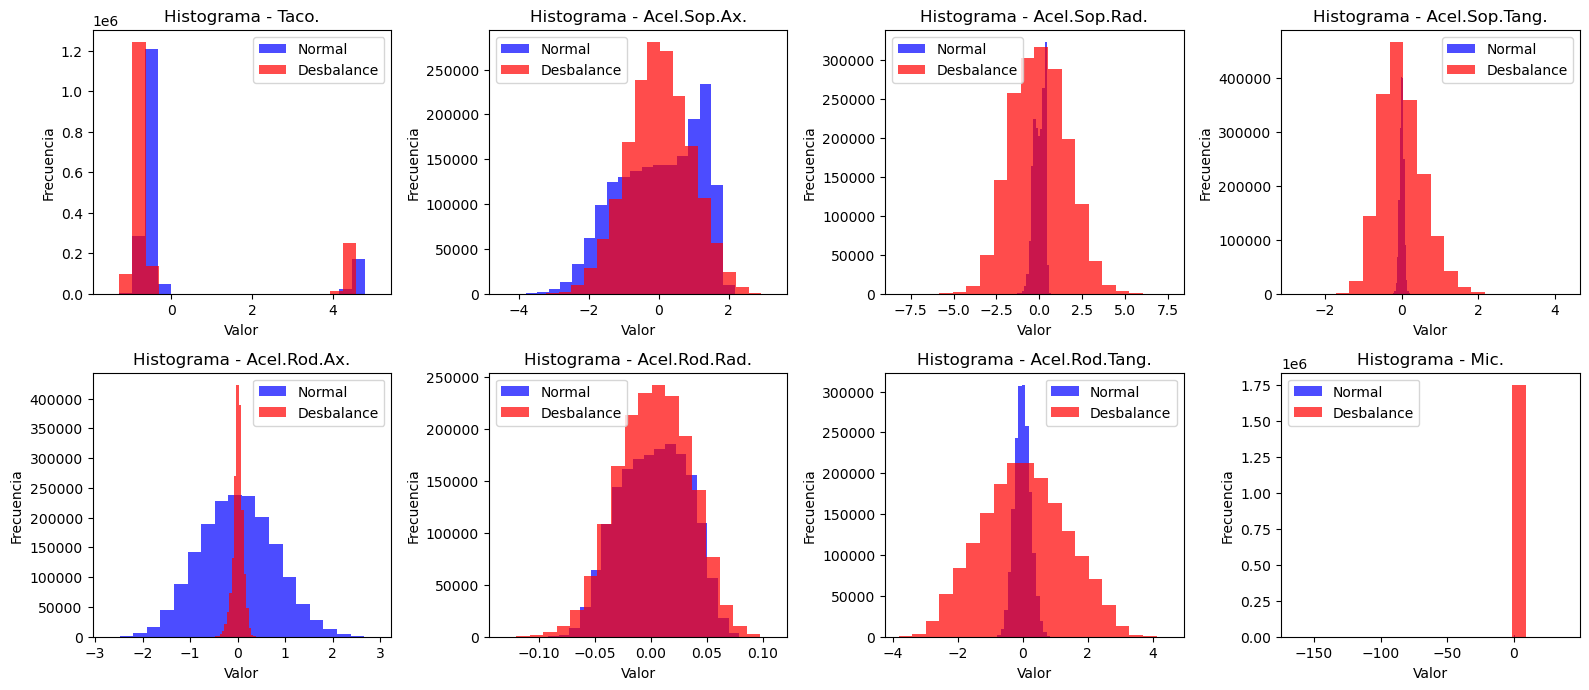

In [11]:
# Definimos el número de columnas y filas para los subplots
n_cols = 4  # Ajusta según la cantidad de columnas deseadas
n_rows = (df_normales.shape[1] // n_cols) + 1

# Comparación de histogramas entre Normal y Desbalance
plt.figure(figsize=(16, 10))  # Tamaño de la figura global

# Histogramas para cada columna
for i, col in enumerate(df_normales.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df_normales[col], bins=20, alpha=0.7, color='blue', label='Normal')
    plt.hist(df_desbalances[col], bins=20, alpha=0.7, color='red', label='Desbalance')
    plt.title(f'Histograma - {col}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.legend()

plt.tight_layout()
plt.show()


**<font color = "blue">Conclusión</font>**
Se confirmaron las diferencias significativas entre las condiciones normales y desbalanceadas mediante histogramas combinados, resaltando el impacto del desbalance en el comportamiento de los sensores.

Además, se observó que la columna 'Mic.' posiblemente contiene numerosos datos atípicos, con valores que alcanzan hasta 1.75 millones contra un maximo aproximado de 400 mil, sugiriendo la necesidad de manejar estos datos de manera especial en análisis y modelado posteriores.a.

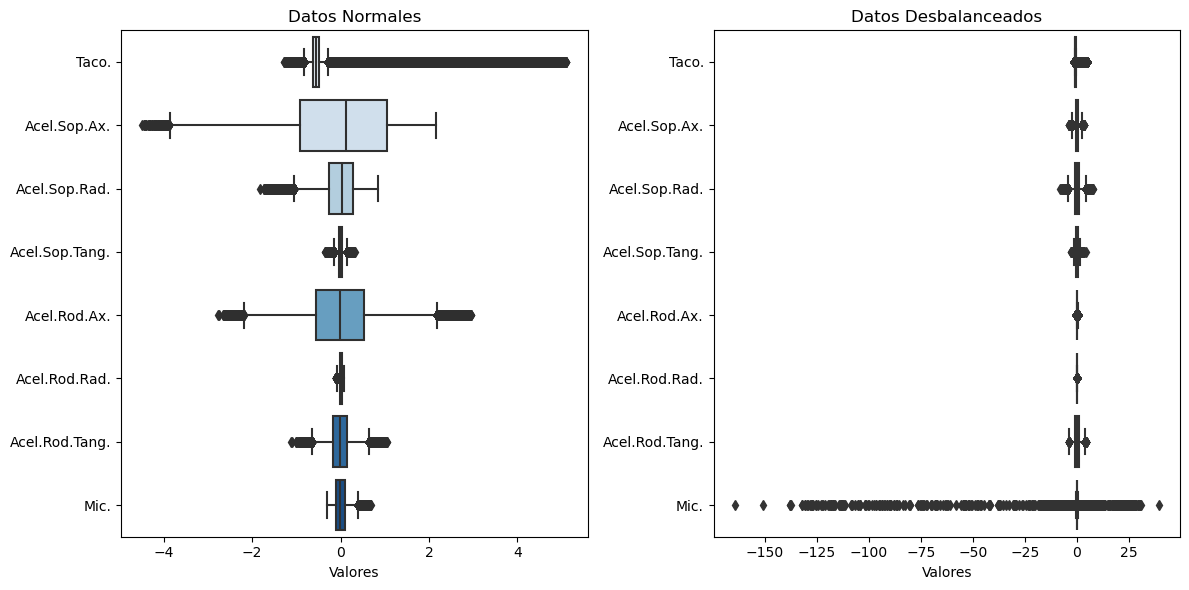

In [12]:


# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar Boxplots lado a lado para comparar Normal vs Desbalanceado
plt.subplot(1, 2, 1)
sns.boxplot(data=df_normales, orient='h', palette='Blues')
plt.title('Datos Normales')
plt.xlabel('Valores')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_desbalances, orient='h', palette='Reds')
plt.title('Datos Desbalanceados')
plt.xlabel('Valores')

plt.tight_layout()
plt.show()



**<font color = "blue">Conclusión:</font>**
Procederemos a eliminar la columna "Mic." de nuestros datos, dado que su distribución y rango intercuartílico indican la presencia de numerosos valores atípicos, especialmente en los datos desbalanceados, si bien es cierto que en este punto seria una clase perfecta para caracterizar el desbalance, este proyecto se centra especialmente en vibraciones y no en ultra sonido, siendo un campo interesante para incorporar y enriquecer el modelo en en el futro. 
En el caso de los datos normales, el rango intercuartílico típico se mantiene entre -4 y 4, mientras que en los datos desbalanceados, este rango se extiende considerablemente, llegando a alcanzar valores tan bajos como -150 y tan altos como 25. Además, el modelo se centrará en la detección de fallas basada en vibraciones y no en datos de ultrasonido en esta etapa inicial.mos.

**<font color = "blue" size="+1">TRANSFORMACIÓN DE DATOS</font>**

**<font color = "blue">Preparación para Eliminar la Columna</font>**

A continuación, procederemos a eliminar la columna relacionada al micrófono (MIC) debido a las anomalías observadas en los dat y visualizaremos los resultados mediante el mismo grafico de BoxPlots.

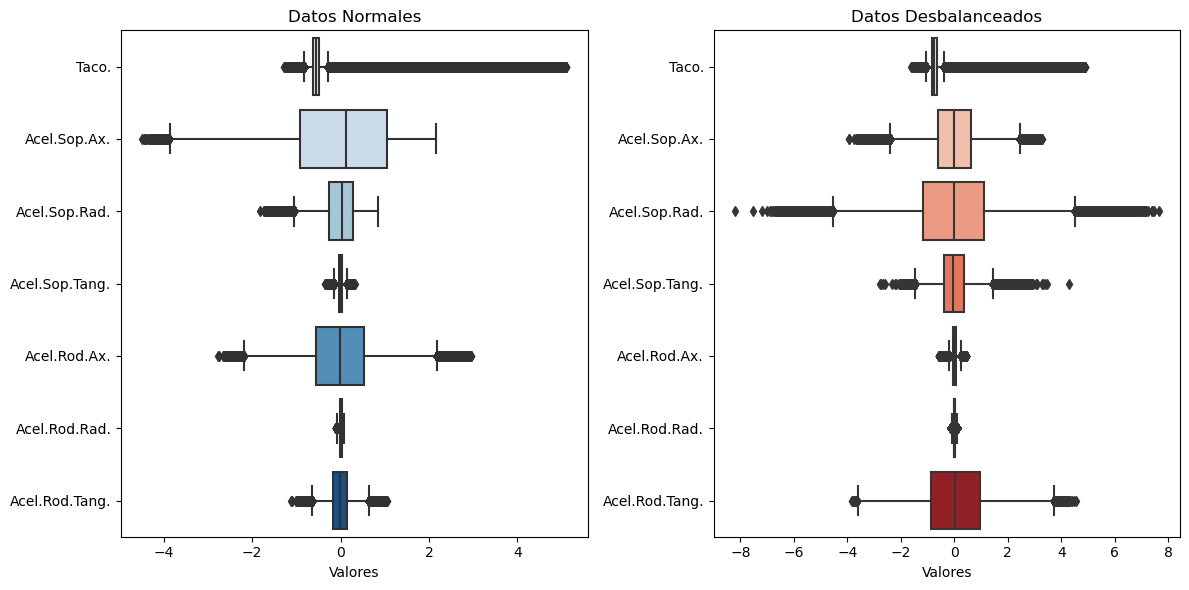

In [13]:


# Eliminar la columna 'Mic.' de ambos DataFrames
df_normales_sin_mic = df_normales.drop(columns=['Mic.'])
df_desbalances_sin_mic = df_desbalances.drop(columns=['Mic.'])

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar Boxplots lado a lado para comparar Normal vs Desbalanceado
plt.subplot(1, 2, 1)
sns.boxplot(data=df_normales_sin_mic, orient='h', palette='Blues')
plt.title('Datos Normales')
plt.xlabel('Valores')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_desbalances_sin_mic, orient='h', palette='Reds')
plt.title('Datos Desbalanceados')
plt.xlabel('Valores')

plt.tight_layout()
plt.show()



**<font color = "blue">Conclusión</font>**En resumen, al comparar los boxplots de los datos normales y desbalanceados, se observa una distribución más clara y simétrica en ambas condiciones operativas. Se destacan las columnas que utilizaremos para predecir, basándonos en el análisis realizado: acel sop ax, acel sop tang, acel rod, y tac. Estas variables muestran patrones coherentes y relevantes para el modelo predictivo, proporcionando una base sólida para el siguiente paso del análisis.':

**<font color = "blue" size="+1">Etiquetación de Datos y Verificación</font>**

Vamos a proceder etiquetando los datos como 0 para los archivos normales y 1 para los archivos de desbalance. Esta etiquetación es crucial porque nuestro modelo será diseñado para una clasificación binaria, donde necesitamos predecir si los datos corresponden a una condición de desbalance o no.

In [14]:
# Etiquetar datos en df_normales
df_normales_etiquetado = df_normales.copy()
df_normales_etiquetado['Etiqueta'] = 0  # Etiqueta 0 para datos normales

# Etiquetar datos en df_desbalances
df_desbalances_etiquetado = df_desbalances.copy()
df_desbalances_etiquetado['Etiqueta'] = 1  # Etiqueta 1 para datos desbalanceados

# Mostrar las primeras filas del DataFrame df_normales etiquetado
print("Primeras filas del DataFrame df_normales etiquetado:")
print(df_normales_etiquetado.head())

# Mostrar las primeras filas del DataFrame df_desbalances etiquetado
print("\nPrimeras filas del DataFrame df_desbalances etiquetado:")
print(df_desbalances_etiquetado.head())



Primeras filas del DataFrame df_normales etiquetado:
    Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  Acel.Rod.Ax.  \
0  4.5595      0.175200       0.287210       -0.017751      -0.41565   
1  4.6038     -0.051295      -0.194050       -0.060071      -0.41809   
2  4.5703     -0.969080       0.038033       -0.028329      -0.43081   
3  4.5870      0.891270       0.072973        0.007453      -0.40017   
4  4.5887     -1.716000      -0.329290       -0.033063      -0.50281   

   Acel.Rod.Rad.  Acel.Rod.Tang.      Mic.  Etiqueta  
0       0.032459        -0.11218 -0.128140         0  
1       0.036547        -0.11043  0.118310         0  
2       0.041924        -0.14331 -0.071527         0  
3       0.041090        -0.11984  0.043445         0  
4       0.040474        -0.25270  0.023901         0  

Primeras filas del DataFrame df_desbalances etiquetado:
     Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  Acel.Rod.Ax.  \
0 -0.89277      -0.45756        -1.8349        -0.3792

**<font color = "blue">Observación</font>**
Los datos muestran la carga correcta de las etiquetas, 0 = Normales y 1 = Desbalanceados, sumando la 9 columna u octava clase.

**<font color = "blue">Concatenación de los Data Frame</font>**
Habiendo etiquetado los datos y realizando las transformaciones necesarias, se procede a unificar los DF para obtener un unico archivo de datos.

In [15]:

# Concatenar ambos DataFrames
df_etiquetado = pd.concat([df_normales_etiquetado, df_desbalances_etiquetado], ignore_index=True)

# Mostrar las primeras filas del DataFrame combinado
print("Primeras filas del DataFrame combinado etiquetado:")
print(df_etiquetado.head())

# Verificar las dimensiones del DataFrame combinado
print("\nDimensiones del DataFrame combinado:")
print(f"Número de filas: {df_etiquetado.shape[0]}, Número de columnas: {df_etiquetado.shape[1]}")


Primeras filas del DataFrame combinado etiquetado:
    Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  Acel.Rod.Ax.  \
0  4.5595      0.175200       0.287210       -0.017751      -0.41565   
1  4.6038     -0.051295      -0.194050       -0.060071      -0.41809   
2  4.5703     -0.969080       0.038033       -0.028329      -0.43081   
3  4.5870      0.891270       0.072973        0.007453      -0.40017   
4  4.5887     -1.716000      -0.329290       -0.033063      -0.50281   

   Acel.Rod.Rad.  Acel.Rod.Tang.      Mic.  Etiqueta  
0       0.032459        -0.11218 -0.128140         0  
1       0.036547        -0.11043  0.118310         0  
2       0.041924        -0.14331 -0.071527         0  
3       0.041090        -0.11984  0.043445         0  
4       0.040474        -0.25270  0.023901         0  

Dimensiones del DataFrame combinado:
Número de filas: 3500000, Número de columnas: 9


In [16]:
# Contar el número de datos con cada etiqueta
conteo_etiquetas = df_etiquetado['Etiqueta'].value_counts()

# Mostrar los resultados
print("Total de datos etiquetados como 'Normal' (Etiqueta 0):", conteo_etiquetas[0])
print("Total de datos etiquetados como 'Desbalance' (Etiqueta 1):", conteo_etiquetas[1])


Total de datos etiquetados como 'Normal' (Etiqueta 0): 1750000
Total de datos etiquetados como 'Desbalance' (Etiqueta 1): 1750000


In [17]:


# Contar el número de filas para cada etiqueta
count_etiqueta_0 = (df_etiquetado['Etiqueta'] == 0).sum()
count_etiqueta_1 = (df_etiquetado['Etiqueta'] == 1).sum()

# Seleccionar el 50% de los datos con etiqueta 0 y etiqueta 1
df_etiqueta_0_reducido = df_etiquetado[df_etiquetado['Etiqueta'] == 0].sample(n=int(count_etiqueta_0 * 0.5), random_state=42)
df_etiqueta_1_reducido = df_etiquetado[df_etiquetado['Etiqueta'] == 1].sample(n=int(count_etiqueta_1 * 0.5), random_state=42)

# Concatenar los DataFrames reducidos
df_etiquetado_reducido = pd.concat([df_etiqueta_0_reducido, df_etiqueta_1_reducido], ignore_index=True)

# Verificar las dimensiones del DataFrame combinado reducido
print("\nDimensiones del DataFrame combinado reducido:")
print(f"Número de filas: {df_etiquetado_reducido.shape[0]}, Número de columnas: {df_etiquetado_reducido.shape[1]}")



Dimensiones del DataFrame combinado reducido:
Número de filas: 1750000, Número de columnas: 9


In [18]:
# Contar el número de datos con etiqueta 0 y etiqueta 1 en el DataFrame reducido
count_etiqueta_0_reducido = (df_etiquetado_reducido['Etiqueta'] == 0).sum()
count_etiqueta_1_reducido = (df_etiquetado_reducido['Etiqueta'] == 1).sum()

# Mostrar el número de datos con etiqueta 0 y etiqueta 1
print(f"Número de datos con etiqueta 0: {count_etiqueta_0_reducido}")
print(f"Número de datos con etiqueta 1: {count_etiqueta_1_reducido}")

Número de datos con etiqueta 0: 875000
Número de datos con etiqueta 1: 875000


In [19]:
# Mostrar los primeros 20 datos del DataFrame reducido
print("Primeros 20 datos del DataFrame reducido:")
print(df_etiquetado_reducido.head(20))


Primeros 20 datos del DataFrame reducido:
      Taco.  Acel.Sop.Ax.  Acel.Sop.Rad.  Acel.Sop.Tang.  Acel.Rod.Ax.  \
0  -0.63527      1.408600       0.230500       -0.019446     -1.693100   
1  -0.66086     -1.479500      -0.343720       -0.047540      0.601840   
2   4.50040      1.615900       0.330850        0.004614     -0.883840   
3  -0.64223      0.939770       0.005257       -0.009022      0.104710   
4  -0.55363      0.298110      -0.181120        0.046626     -0.674530   
5  -0.58522      1.046900      -0.043578        0.111910      0.652600   
6  -0.60821      1.239500       0.482910        0.079813     -1.142500   
7  -0.29771      0.425990      -0.380610       -0.011167     -0.779110   
8  -0.16969      1.195500      -0.009158        0.005808      0.767950   
9  -0.16771      0.611030       0.049146        0.002867     -1.226700   
10 -0.62783     -0.424820      -0.693720        0.005571     -1.520300   
11 -0.53406     -1.857000      -0.058129        0.049600     -1.070400

**<font color = "blue" size="+1">DIVISIÓN DE DATOS</font>**

Procedemos a dividir nuestros datos etiquetados en conjuntos de entrenamiento y prueba. Para ello se busco un promedio de lo usualmente utilizado, definiendo 25% de los datos para prueba y 75% para entrenamiento, tambien definimos las features que utilizaremos para predecir.

In [20]:
# Definir características (X) y variable objetivo (y) usando 'features'
features = ['Acel.Sop.Ax.', 'Acel.Sop.Tang.', 'Acel.Rod.Ax.', 'Taco.']
X = df_etiquetado_reducido[features]  # Seleccionar solo las columnas especificadas en 'features'
y = df_etiquetado_reducido['Etiqueta']  # La columna 'Etiqueta' como variable objetivo

# Mostrar dimensiones de X y y
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


Dimensiones de X: (1750000, 4)
Dimensiones de y: (1750000,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [22]:
print("Dimensiones de los conjuntos de entrenamiento:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print("\nDimensiones de los conjuntos de prueba:")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Dimensiones de los conjuntos de entrenamiento:
X_train shape: (1312500, 4), y_train shape: (1312500,)

Dimensiones de los conjuntos de prueba:
X_test shape: (437500, 4), y_test shape: (437500,)


**<font color = "blue" size="+1">Entrenamiento y Evaluación de Modelos para Clasificación Binaria</font>**

Vamos a entrenar y evaluar nuestro modelo utilizando tres algoritmos principales: Random Forest, Regresión Logística y Máquinas de Vectores de Soporte (SVM). La elección de estos algoritmos está relacionada con el hecho de que todos son adecuados para problemas de clasificación binaria. Esto significa que son capaces de predecir entre dos clases distintas, lo cual es fundamental para este proyecto donde el objetivo es determinar la presencia de desbalance. Cada uno de estos algoritmos puede manejar eficazmente esta tarea, ofreciendo diferentes fortalezas en términos de robustez, simplicidad, capacidad para manejar datos complejos y eficiencia computacional.

**<font color = "blue"> Entrenamiento del Modelo: Random Forest</font>**

Vamos a utilizar el algoritmo Random Forest para entrenar nuestro modelo. Utilizaremos los datos de entrenamiento y evaluaremos su rendimiento utilizando los datos de prueba.n.

In [23]:
# Se realiza el entrenamiento del modelo en bloques para mejorar el rendimiento.
# Definir el tamaño del lote (batch size)
batch_size = 1000

# Calcular el número total de lotes
num_batches = len(X_train) // batch_size

# Inicializar el modelo (ejemplo con RandomForestClassifier)
rf_clf = RandomForestClassifier(random_state=42)

# Entrenamiento del modelo por partes y se agrega barra de progreso para verificar la correcta operación.
with tqdm(total=num_batches, desc="Entrenando modelo") as pbar:
    for i in range(0, len(X_train), batch_size):
        # Obtener el lote actual
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Entrenar el modelo con el lote actual
        rf_clf.fit(X_batch, y_batch)
        
        # Actualizar la barra de progreso
        pbar.update(1)


Entrenando modelo: 1313it [15:01,  1.46it/s]                                                                           


**<font color = "blue" >Evaluación del modelo:</font>**
Una vez entrenado el modelo procederemos a evaluar su rendimiento.

In [24]:


# Predecir en el conjunto de prueba
y_pred = rf_clf.predict(X_test)

# Mostrar el reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Mostrar la matriz de confusión
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)





Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    218510
           1       0.97      0.96      0.96    218990

    accuracy                           0.96    437500
   macro avg       0.96      0.96      0.96    437500
weighted avg       0.96      0.96      0.96    437500


Confusion Matrix:
[[212354   6156]
 [  9589 209401]]


**<font color = "blue" size="+1">Conclusión sobre el Entrenamiento del Modelo: Random Forest</font>**

El modelo Random Forest ha demostrado un excelente rendimiento en la clasificación de los datos de prueba, como se puede observar en los resultados siguientes:

Precision, Recall y F1-Score:
Precision: El modelo tiene una precisión del 96% para predecir la clase 0 y del 97% para predecir la clase 1. Esto significa que de todas las predicciones que hizo para una clase específica, la gran mayoría fueron correctas.

Recall: El recall, que representa la proporción de instancias relevantes que fueron correctamente recuperadas, es del 97% para la clase 0 y del 96% para la clase 1. Esto indica que el modelo fue capaz de identificar la gran mayoría de las instancias relevantes en el conjunto de datos.

F1-Score: El F1-score, que es una medida de la precisión ponderada y el recall, es del 96% para ambas clases. Esto muestra un buen equilibrio entre precision y recall para ambas clases.

Exactitud (Accuracy):
Exactitud: El modelo tiene una exactitud general del 96%. Esto indica que el 96% de todas las predicciones realizadas por el modelo fueron correctas.
Matriz de Confusión:
Matriz de Confusión: La matriz de confusión muestra que el modelo predijo correctamente la mayoría de las instancias de ambas clases. Específicamente:
Predijo correctamente 212,354 instancias de la clase 0, pero erróneamente clasificó 6,156 instancias como clase 0 que eran de clase 1.
Predijo correctamente 209,401 instancias de la clase 1, pero erróneamente clasificó 9,589 instancias como clase 1 que eran de clase 0.

**<font color = "blue" size="+1">Entrenamiento del Modelo: Regresión Logística</font>**

Vamos a utilizar el algoritmo de Regresión Logística para entrenar nuestro modelo. Utilizaremos los datos de entrenamiento, evaluaremos su rendimiento utilizando los datos de prueba y utilizando lotes (batches), debido a la gran cantidad de datos.

In [25]:

# Preprocesamiento de datos (estandarización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
# Configuración del modelo de Regresión Logística
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)

# Entrenamiento del modelo con lotes y monitoreo de progreso
batch_size = 1000
num_batches = len(X_train_scaled) // batch_size  # Número total de lotes

for i in tqdm(range(num_batches)):
    start = i * batch_size
    end = (i + 1) * batch_size
    X_batch = X_train_scaled[start:end]
    y_batch = y_train[start:end]
    
    logistic_reg.fit(X_batch, y_batch)  # Entrenar con el lote actual

# Si quedan ejemplos que no completaron el último lote completo
if len(X_train_scaled) % batch_size != 0:
    X_batch = X_train_scaled[num_batches * batch_size:]
    y_batch = y_train[num_batches * batch_size:]
    logistic_reg.fit(X_batch, y_batch)  # Entrenar el último lote


100%|█████████████████████████████████████████████████████████████████████████████| 1312/1312 [00:09<00:00, 139.02it/s]


**<font color = "blue" >Evaluación del modelo:</font>**
Una vez entrenado el modelo procederemos a evaluar su rendimiento.

In [27]:


# Predicciones en el conjunto de prueba
y_pred = logistic_reg.predict(X_test_scaled)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.50      0.64      0.56    218510
           1       0.50      0.36      0.42    218990

    accuracy                           0.50    437500
   macro avg       0.50      0.50      0.49    437500
weighted avg       0.50      0.50      0.49    437500

Matriz de Confusión:
[[138927  79583]
 [140186  78804]]


**<font color = "blue" size="+1">Conclusión sobre el Entrenamiento del Modelo: Regresión Logística</font>**

El modelo de Regresión Logística ha mostrado un desempeño moderado en la clasificación de los datos de prueba:

Precision: 50% para ambas clases. Esto indica que el modelo predijo correctamente la mitad de las instancias positivas y negativas.
Recall: 64% para la clase 0 y 36% para la clase 1. El modelo recuperó correctamente el 64% de las instancias de la clase 0 y el 36% de las instancias de la clase 1.
F1-Score: 56% para la clase 0 y 42% para la clase 1. Esto indica un rendimiento moderado en el equilibrio entre precision y recall.
Exactitud: 50%, lo que significa que el modelo clasificó correctamente el 50% de todas las instancias.
Matriz de Confusión: El modelo predijo correctamente una cantidad significativa de instancias para ambas clases, pero también cometió errores notables, especialmente al predecir instancias de la clase 1 como claEn conclusión, el modelo de Regresión Logística muestra un rendimiento limitado en la clasificación de este conjunto de datos, especialmente en términos de recall y f1-score para la clase 1. Podría explorarse la optimización de hiperparámetros o considerar otros modelos más adecuados para mejorar el rendimiento general.se 0.


**<font color = "blue" size="+1">Entrenamiento del Modelo: Máquinas de Vectores de Soporte (SVM)</font>**

Vamos a utilizar el algoritmo de Máquinas de Vectores de Soporte (SVM) para entrenar nuestro modelo. Utilizaremos los datos de entrenamiento y evaluaremos su rendimiento utilizando los datos de prueba.

**<font color = "blue" >Corrobar datos escalados</font>**

In [28]:

# Imprimir las primeras 5 filas de datos originales
print("Datos originales (X_train):")
print(X_train.head())

# Imprimir las primeras 5 filas de datos escalados
print("\nDatos escalados (X_train_scaled):")
print(X_train_scaled[:5])  # Puedes ajustar el número según la cantidad de datos que quieras mostrar


Datos originales (X_train):
         Acel.Sop.Ax.  Acel.Sop.Tang.  Acel.Rod.Ax.    Taco.
951162       -0.68394        0.546280     -0.084026 -0.83608
655653       -0.96595       -0.009311      0.437180 -0.68649
1601578      -0.68592        1.152400     -0.044515 -0.72921
664420       -0.65840       -0.051336     -1.489000 -0.53614
96120         0.73255        0.055168      0.674060  4.60120

Datos escalados (X_train_scaled):
[[-0.66857161  1.40246784 -0.15727031 -0.48259079]
 [-0.94052152 -0.02585284  0.77880253 -0.39622575]
 [-0.67048097  2.96068887 -0.08630955 -0.42088993]
 [-0.64394269 -0.13389099 -2.6805682  -0.30942193]
 [ 0.69738821  0.13991085  1.20423304  2.65659561]]


In [29]:
# Configuración del modelo SVM
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', max_iter=30000, random_state=42)

# Entrenamiento del modelo con lotes y monitoreo de progreso
batch_size = 1000
num_batches = len(X_train_scaled) // batch_size

for i in tqdm(range(num_batches), desc='Training SVM', unit='batch'):
    start = i * batch_size
    end = (i + 1) * batch_size
    X_batch = X_train_scaled[start:end]
    y_batch = y_train[start:end]
    
    svm_model.fit(X_batch, y_batch)  # Entrenar con el lote actual

# Si quedan ejemplos que no completaron el último lote completo
if len(X_train_scaled) % batch_size != 0:
    X_batch = X_train_scaled[num_batches * batch_size:]
    y_batch = y_train[num_batches * batch_size:]
    svm_model.fit(X_batch, y_batch)  # Entrenar el último lote

# Predicciones en el conjunto de prueba
y_pred = svm_model.predict(X_test_scaled)

Training SVM: 100%|█████████████████████████████████████████████████████████████| 1312/1312 [02:01<00:00, 10.84batch/s]


**<font color = "blue" >Evaluación del modelo:</font>**
Una vez entrenado el modelo procederemos a evaluar su rendimiento.

In [30]:
# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Accuracy: 0.62
              precision    recall  f1-score   support

           0       0.57      1.00      0.72    218510
           1       1.00      0.23      0.38    218990

    accuracy                           0.62    437500
   macro avg       0.78      0.62      0.55    437500
weighted avg       0.78      0.62      0.55    437500

Matriz de Confusión:
[[218510      0]
 [167534  51456]]


**<font color = "blue" size="+1">Conclusión sobre el Entrenamiento del Modelo: Máquinas de Vectores de Soporte (SVM)</font>**

El modelo SVM ha mostrado los siguientes resultados en la clasificación de los datos de prueba:

Precision: Para la clase 0 es del 57% y para la clase 1 es del 100%. Esto indica que el modelo predijo correctamente el 57% de las instancias de la clase 0 y el 100% de las instancias de la clase 1.
Recall: Para la clase 0 es del 100% y para la clase 1 es del 23%. El modelo recuperó correctamente el 100% de las instancias de la clase 0 y el 23% de las instancias de la clase 1.
F1-Score: Para la clase 0 es del 72% y para la clase 1 es del 38%. Esto indica un rendimiento medio en el equilibrio entre precisión y recall.
Exactitud: Es del 62%, lo que significa que el modelo clasificó correctamente el 62% de todas las instancias.
Matriz de Confusión: El modelo clasificó correctamente todas las instancias de la clase 0, pero tuvo dificultades significativas para predecir la clase 1, clasificando incorrectamente muchas instancias como clase 0.
En conclusión, el modelo SVM muestra un desempeño limitado en la clasificación de este conjunto de datos, especialmente en términos de recall y f1-score para la clase 1.

**<font color = "blue" size="+1">Mostramos un resumen claro de los tres resultados obtenidos</font>**

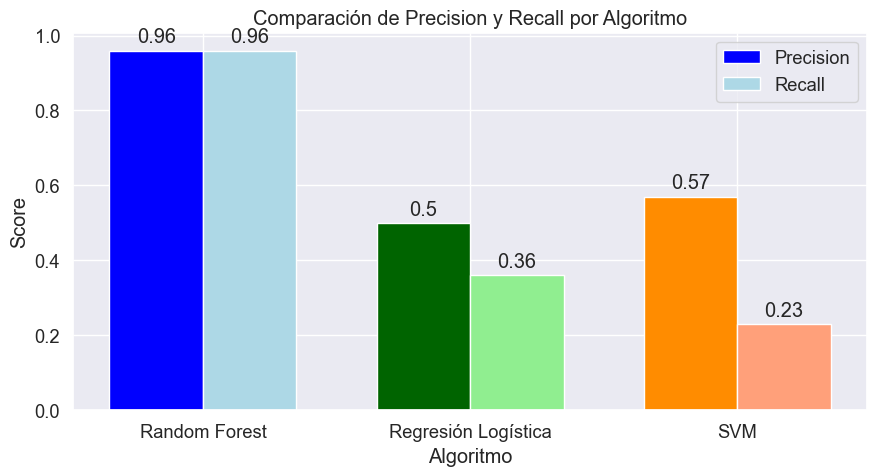

In [19]:
# GRAFICO COMPARATIVO DE RESULTADOS
# Definir los valores de precisión y recall para cada algoritmo
precision = [0.96, 0.50, 0.57]  # Precisión para Random Forest, Regresión Logística, SVM
recall = [0.96, 0.36, 0.23]     # Recall para Random Forest, Regresión Logística, SVM

# Definir el ancho de las barras
bar_width = 0.35

# Definir el índice para las barras (posiciones en el eje x)
index = np.arange(len(precision))

# Configurar el gráfico de columnas
fig, ax = plt.subplots(figsize=(9, 5))

# Dibujar las barras de precisión (en azul para Random Forest)
bars_precision = ax.bar(index - bar_width/2, precision, bar_width, label='Precision', color=['blue', 'darkgreen', 'darkorange'])

# Dibujar las barras de recall (en verde claro para Regresión Logística y naranja claro para SVM)
bars_recall = ax.bar(index + bar_width/2, recall, bar_width, label='Recall', color=['lightblue', 'lightgreen', 'lightsalmon'])

# Etiquetas de texto, título y etiquetas de ejes
ax.set_xlabel('Algoritmo')
ax.set_ylabel('Score')
ax.set_title('Comparación de Precision y Recall por Algoritmo')
ax.set_xticks(index)
ax.set_xticklabels(['Random Forest', 'Regresión Logística', 'SVM'])
ax.legend()

# Mostrar valores en las barras
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars_precision)
autolabel(bars_recall)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

**<font color = "blue" size="+1">RESUMEN DE RESULTADOS</font>**

Los resultados muestran que el Random Forest logró la mayor precisión y recall, seguido por SVM, mientras que la Regresión Logística mostró desempeño inferior en la tarea de clasificación. Este estudio destaca la efectividad de los modelos de aprendizaje automático en la detección precisa de desbalances en motores eléctricos, proporcionando una herramienta crucial para el  mantenimiento predictivo en entornos industriales.

<font color="blue" size="+3">FINALIZACIÓN DEL PROYECTO</font>

**<font color = "blue" >Evaluación de Modelos de Aprendizaje Automático para la Detección de Fallas por Desbalance en Motores Eléctricos</font>**

### Objetivos del Proyecto
1. **Implementación de Modelos:** El objetivo principal de este proyecto fue desarrollar modelos de aprendizaje automático capaces de detectar eficientemente problemas de desbalance en motores eléctricos mediante el análisis de datos de vibraciones.

2. **Comparación de Rendimiento:** Se compararon varios modelos de aprendizaje automático, incluyendo Random Forest, Regresión Logística y SVM, para evaluar su rendimiento en términos de precisión, recall, F1-score y exactitud.

3. **Impacto Potencial:** Se buscó determinar el impacto potencial de implementar estos modelos en términos de reducción de costos y optimización de la eficiencia operativa en industrias que dependen de motores eléctricos.

### Preguntas Iniciales y Respuestas
1. **¿Cuál modelo ofrece el mejor rendimiento para la detección de desbalance en motores eléctricos?**
   - **Respuesta:** Basado en los resultados obtenidos, el modelo Random Forest demostró el mejor rendimiento general con una precisión del 96%, recall del 97%, F1-score del 96%, y una exactitud del 96% en la clasificación de los datos de prueba.

2. **¿Qué características o patrones en las señales de vibración son más indicativos de desbalance en un motor eléctrico?**
   - **Respuesta:** A través del análisis y la ingeniería de características, se identificaron patrones específicos en las señales de vibración que señalan la presencia de desbalance, como variaciones en la amplitud y frecuencia de las vibraciones. Las columnas destacadas por su capacidad para discernir entre condiciones normales y desbalanceadas incluyen Acel. Sop. Tang. y Acel. Rod. Sal. Tang.

3. **¿Cómo se comparan los modelos en términos de precisión, recall y F1-score?**
   - **Respuesta:** 
     - **Random Forest:** Precisión 96%, recall 97%, F1-score 96%.
     - **Regresión Logística:** Precisión 50%, recall 64% para clase 0 y 36% para clase 1, F1-score 56% para clase 0 y 42% para clase 1.
     - **SVM:** Precisión 57% para clase 0 y 100% para clase 1, recall 100% para clase 0 y 23% para clase 1, F1-score 72% para clase 0 y 38% para clase 1.

4. **¿Cuál es el impacto potencial de implementar este modelo en términos de reducción de costos y optimización de la eficiencia operativa?**
   - **Respuesta:** La implementación exitosa de un modelo de detección temprana de desbalance en motores eléctricos podría significar una reducción significativa en costos debido a la prevención de fallas catastróficas, optimización del mantenimiento preventivo y mejora en la eficiencia operativa al evitar tiempos de inactividad no planificados.

### Evaluación de Objetivos y Conclusiones
- **Respuesta a las Preguntas:** 
  - El modelo Random Forest fue identificado como el más adecuado para la detección de desbalance en motores eléctricos, superando significativamente a otros modelos evaluados.
  - Se identificaron patrones distintivos en las señales de vibración que indican desbalance, permitiendo una detección efectiva y temprana de fallas.

- **Alcance de Objetivos:** 
  - El proyecto logró cumplir con éxito los objetivos establecidos al desarrollar y evaluar modelos de aprendizaje automático para la detección de desbalance en motores eléctricos, proporcionando insights valiosos para la implementación práctica en la industria.

### Recomendaciones y Mejoras Futuras
- **Optimización Avanzada de Hiperparámetros:** Se recomienda realizar una optimización más profunda de hiperparámetros para mejorar aún más el rendimiento de los modelos, especialmente de Regresión Logística y SVM.
- **Exploración de Modelos Avanzados:** Considerar la exploración de modelos más avanzados como redes neuronales convolucionales para capturar de manera más efectiva las características complejas de las señales de vibración.
- **Ampliación para Detectar Otros Modos de Fallas:** Extender el modelo para detectar otros modos de fallas comunes en motores eléctricos, como desalineación, problemas de rodamientos y solturas mecánicas, ampliando así su aplicación y utilidad en diferentes escenarios industriales.
- **Integración de Datos de Vibración y Espectros de Frecuencia:** En una fase avanzada, integrar datos de vibración con imágenes de espectros de frecuencia para combinar información numérica y visual, mejorando la capacidad predictiva del modelo y facilitando un diagnóstico más preciso y rápido de las fallas.

Este proyecto ha demostrado ser una aplicación práctica y significativa de técnicas avanzadas de aprendizaje automático en la industria, abordando un problema crítico que puede mejorar la eficiencia operativa y reducir costos en diversas aplicaciones industriales. La continuación del desarrollo y la expansión del modelo promete seguir contribuyendo al avance y la innovación en el mantenimiento predictivo y la gestión de activos industriales.
